# **🧰 1. Data Preprocessing & Cleaning**

📌 Import needed libraries






In [6]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


In [7]:
# Fetch dataset
heart_disease = fetch_ucirepo(id=45)

# Data (as pandas DataFrames)
X = heart_disease.data.features
y = heart_disease.data.targets

# Examine data
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


In [8]:
print(f"Number of missing values before cleaning: {X.isnull().sum().sum()}")

# Remove rows with any missing values
rows_removed = X[X.isnull().any(axis=1)].index
X_cleaned = X.dropna()
y_cleaned = y.drop(rows_removed)

print(f"Number of missing values after cleaning: {X_cleaned.isnull().sum().sum()}")


Number of missing values before cleaning: 6
Number of missing values after cleaning: 0


In [11]:
X_cleaned.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)

## **📉 2. Dimensionality Reduction (PCA)**

📌 Import needed libraries

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
# Apply PCA without specifying number of components initially
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

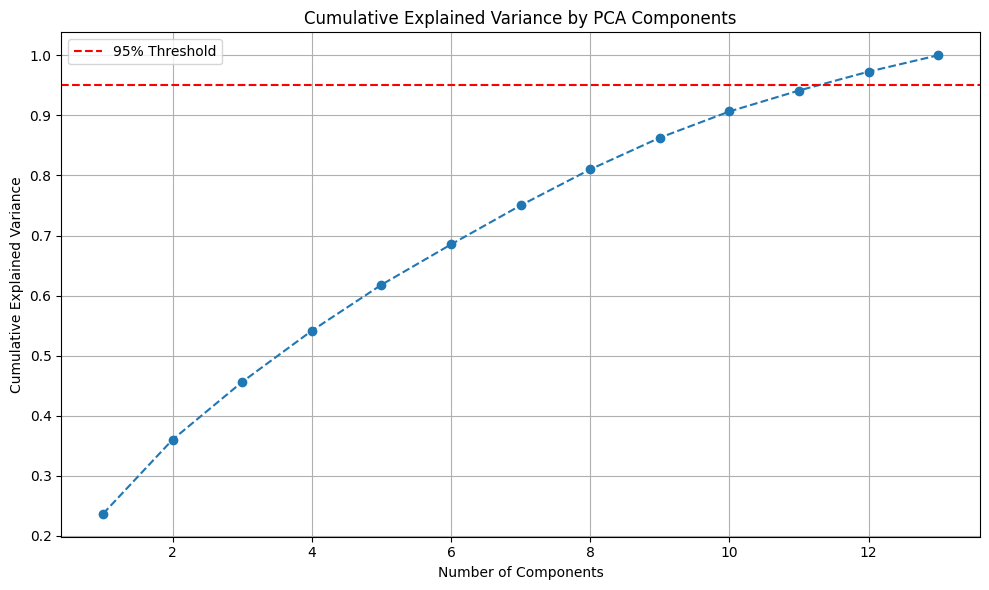

In [16]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
threshold = 0.95

try:
    n_components = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= threshold) + 1
except StopIteration:
    n_components = len(cumulative_variance)

print(f"Selected number of components: {n_components}")

Selected number of components: 12


In [19]:
pca_opt = PCA(n_components=n_components)
X_pca_reduced = pca_opt.fit_transform(X_scaled)

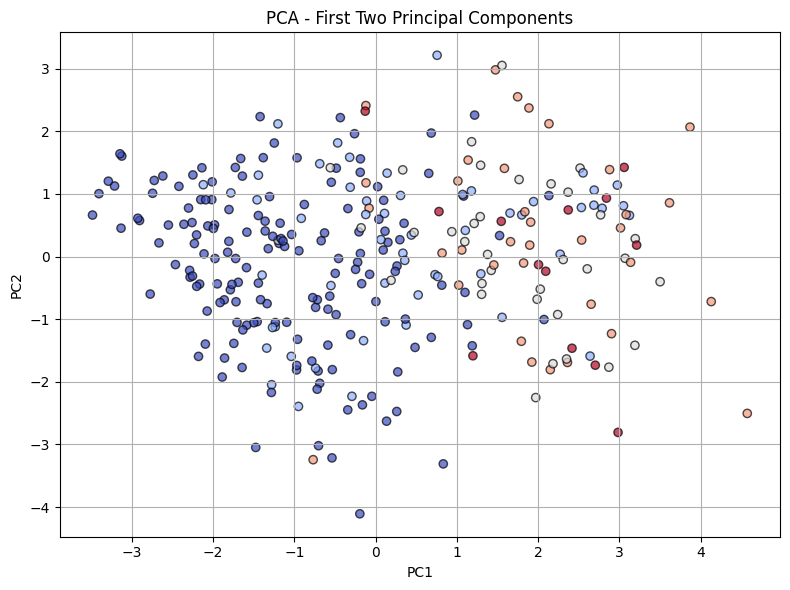

In [20]:
if n_components >= 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y_cleaned.values.ravel(), cmap='coolwarm', edgecolor='k', alpha=0.7)
    plt.title('PCA - First Two Principal Components')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **🔎 Step 3: Feature Selection**

📌 Import needed libraries

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

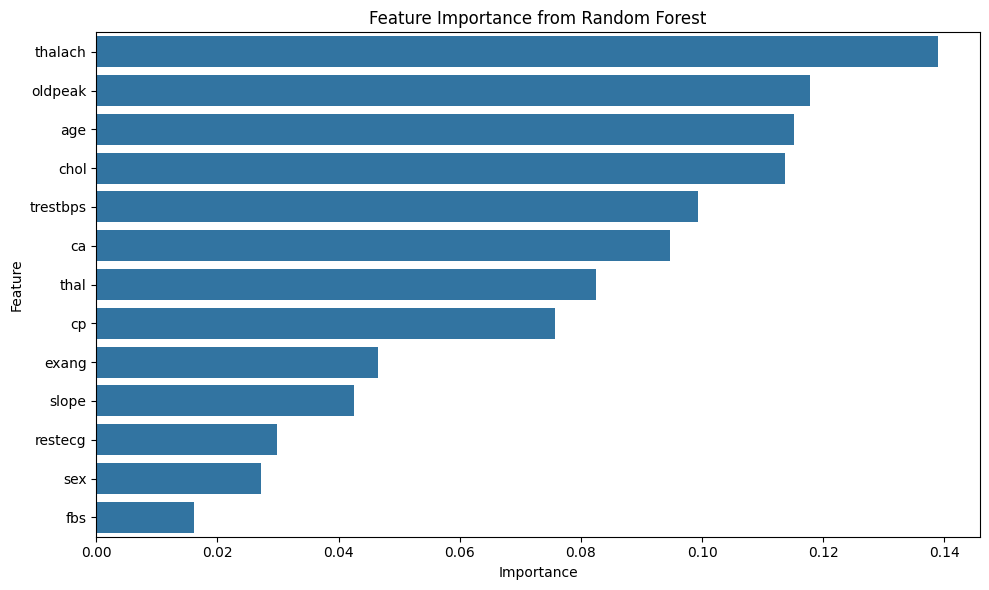

In [22]:
# Train a Random Forest to get feature importances
rf = RandomForestClassifier(random_state=42)
rf.fit(X_cleaned, y_cleaned.values.ravel())

# Feature importances
importances = rf.feature_importances_
feature_names = X_cleaned.columns

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()

In [23]:
# Use RFE with Logistic Regression (can use other estimators)
model = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=model, n_features_to_select=8)
rfe.fit(X_cleaned, y_cleaned.values.ravel())

# Selected features by RFE
selected_rfe = X_cleaned.columns[rfe.support_]
print("Selected Features by RFE:", selected_rfe.tolist())

Selected Features by RFE: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca']


In [24]:
# Apply Chi-Square Test (features must be non-negative, so abs() if needed)
chi_selector = SelectKBest(score_func=chi2, k=8)
X_chi = chi_selector.fit_transform(abs(X_cleaned), y_cleaned.values.ravel())

# Selected features by Chi-Square Test
selected_chi = X_cleaned.columns[chi_selector.get_support()]
print("Selected Features by Chi-Square Test:", selected_chi.tolist())

Selected Features by Chi-Square Test: ['age', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']


In [25]:
# Combine selected features from RFE and Chi-Square (union or intersection)
final_features = list(set(selected_rfe).union(set(selected_chi)))
print("Final Selected Features:", final_features)

# Reduced dataset with selected features
X_selected = X_cleaned[final_features]

Final Selected Features: ['sex', 'ca', 'oldpeak', 'thalach', 'slope', 'trestbps', 'exang', 'fbs', 'restecg', 'thal', 'cp', 'age', 'chol']


# **# Step 4: Supervised Learning — classification Models**

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)
}

In [35]:
for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())

In [37]:
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)

    # For multiclass, get the predicted probabilities for all classes
    y_proba = model.predict_proba(X_test)

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC AUC': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    }

import pandas as pd
metrics_df = pd.DataFrame(results).T
print(metrics_df)

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.616667   0.591111  0.616667  0.572057  0.877937
Decision Tree        0.483333   0.520225  0.483333  0.497238  0.657514
Random Forest        0.516667   0.403252  0.516667  0.452968  0.860818
SVM                  0.533333   0.284444  0.533333  0.371014  0.810601


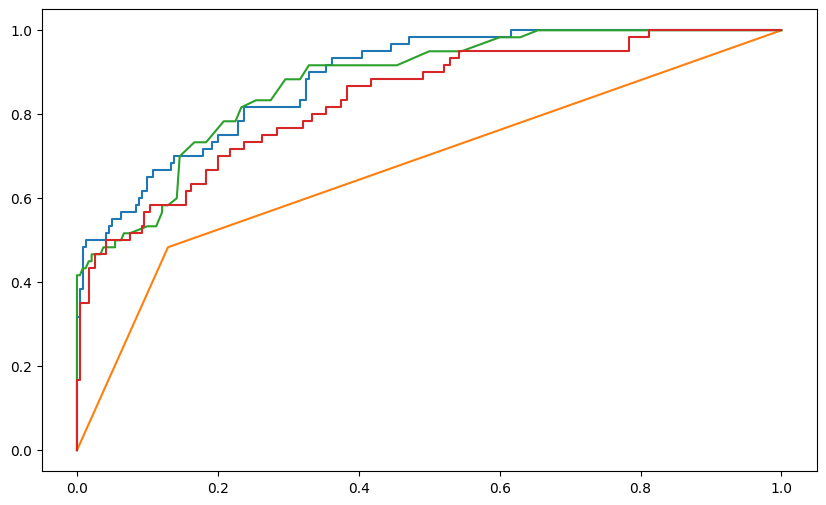

In [40]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output for multiclass ROC curve plotting
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'{name} (micro-average AUC = {roc_auc["micro"]:.2f})')

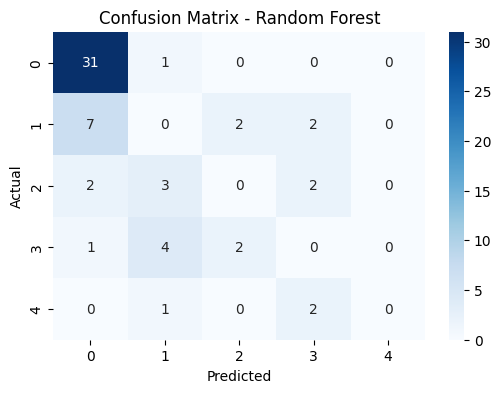

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

best_model = models['Random Forest']
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# 🧩 Step 6: Unsupervised Learning — Clustering

In [43]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

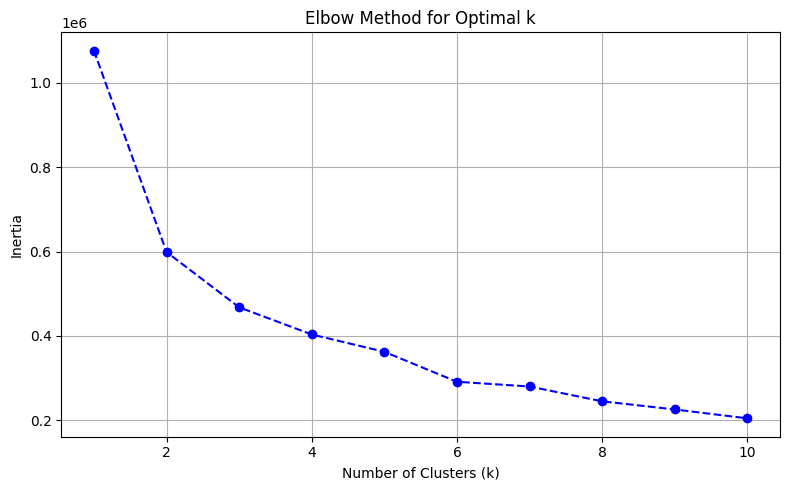

In [44]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_selected)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_selected)
print(f"Silhouette Score (K-Means, k=2): {silhouette_score(X_selected, clusters_kmeans):.2f}")

Silhouette Score (K-Means, k=2): 0.39


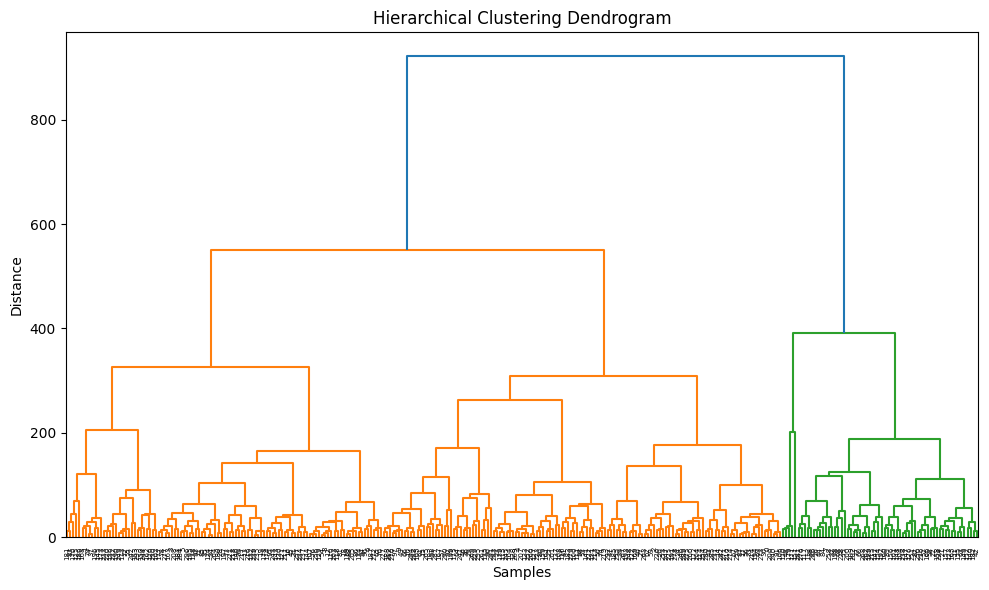

In [46]:
plt.figure(figsize=(10, 6))
linked = linkage(X_selected, 'ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [47]:
clusters_hier = fcluster(linked, 2, criterion='maxclust')
print(f"Silhouette Score (Hierarchical, k=2): {silhouette_score(X_selected, clusters_hier):.2f}")

Silhouette Score (Hierarchical, k=2): 0.39


# **️ Step 7: Model Training and Evaluation**🛠



In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

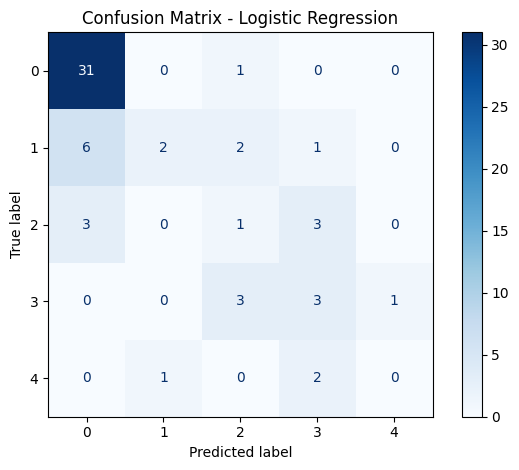

In [49]:
best_model_name = metrics_df['F1 Score'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

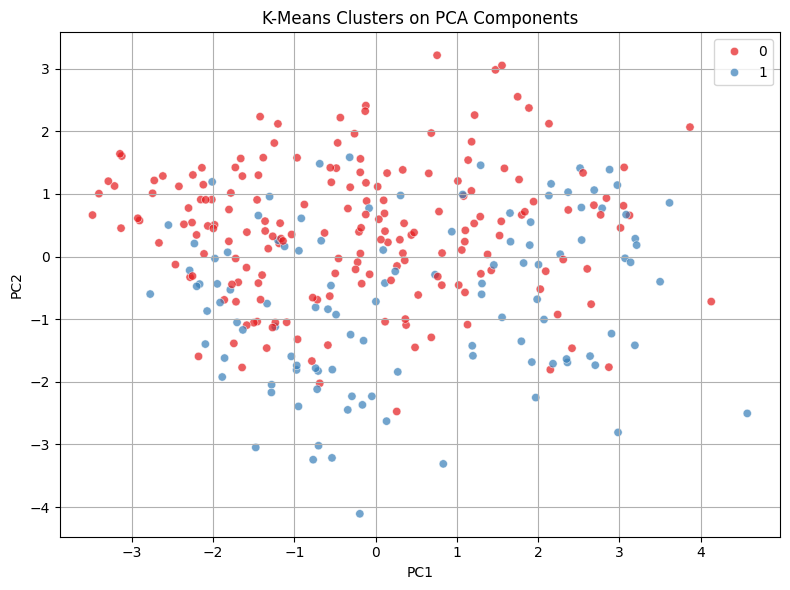

In [50]:
if n_components >= 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=X_pca_reduced[:, 0], y=X_pca_reduced[:, 1],
        hue=clusters_kmeans, palette='Set1', legend='full', alpha=0.7
    )
    plt.title("K-Means Clusters on PCA Components")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

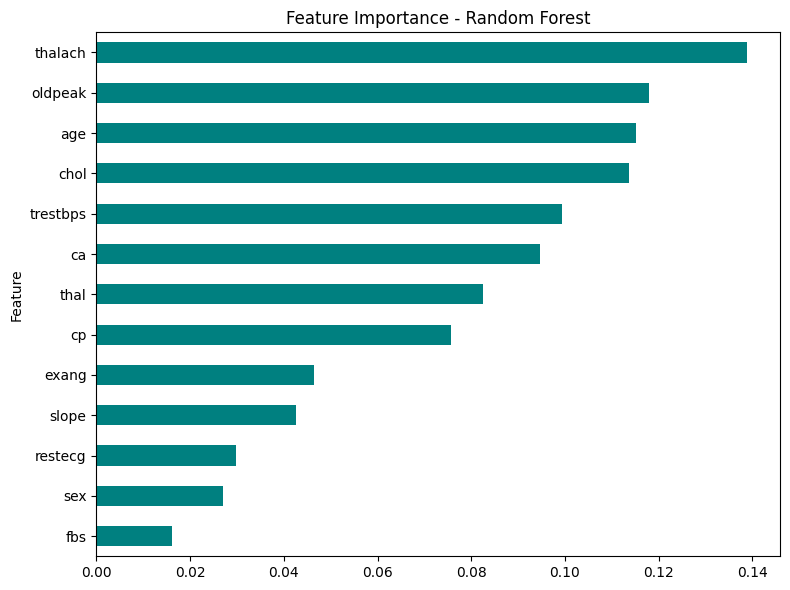

In [51]:
feat_imp_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(8,6), color='teal')
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 7: **Prediction** **on New Data (Inference)**

In [52]:
# Example new data input (replace with real values)
new_data_dict = {
    'age': 55,
    'sex': 1,
    'cp': 3,
    'trestbps': 140,
    'chol': 250,
    'fbs': 0,
    'restecg': 1,
    'thalach': 150,
    'exang': 0,
    'oldpeak': 2.3,
    'slope': 3,
    'ca': 0,
    'thal': 6
}

new_data_df = pd.DataFrame([new_data_dict])

In [56]:
# Ensure same feature order as training data
new_data_selected = new_data_df[final_features]  # assumes final_features is a list of correct, ordered names

# Reorder columns to match training feature order exactly
new_data_selected = new_data_selected.loc[:, scaler.feature_names_in_]

# Scale using the trained scaler
new_data_scaled = scaler.transform(new_data_selected)

In [57]:
# Make prediction
prediction = best_model.predict(new_data_scaled)
prediction_proba = best_model.predict_proba(new_data_scaled)

# Display results
print(f"✅ Predicted Class: {prediction[0]}")
print(f"📊 Prediction Probability (Positive Class): {prediction_proba[0][1]:.4f}")

✅ Predicted Class: 3
📊 Prediction Probability (Positive Class): 0.1019
